In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

2024-11-10 23:20:17.970579: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 23:20:17.974321: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 23:20:18.021851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 23:20:21.631862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Step 1: Load Preprocessed SEC Dataset
print("Loading preprocessed SEC dataset...")
sec_data = pd.read_csv('sec_filings_10000_preprocessed.csv')
print("SEC dataset loaded successfully.")

Loading preprocessed SEC dataset...
SEC dataset loaded successfully.


In [3]:
# Step 2: Load and Preprocess yfinance Data
def get_yfinance_data(ticker, start_date, end_date):
    print(f"Fetching yfinance data for {ticker} from {start_date} to {end_date}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.ffill()  # Forward fill missing values
    print("yfinance data fetched and preprocessed successfully.")
    return data

ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-11-09'
yf_data = get_yfinance_data(ticker, start_date, end_date)

# Preprocess yfinance Data
print("Handling missing values for yfinance data...")
critical_columns_yf = ['Close', 'Open', 'High', 'Low', 'Volume']
existing_critical_columns_yf = [col for col in critical_columns_yf if col in yf_data.columns]
if existing_critical_columns_yf:
    imputer = KNNImputer(n_neighbors=5)
    yf_data[existing_critical_columns_yf] = imputer.fit_transform(yf_data[existing_critical_columns_yf])
print("Missing values handled successfully.")

Fetching yfinance data for AAPL from 2020-01-01 to 2024-11-09...


[*********************100%***********************]  1 of 1 completed

yfinance data fetched and preprocessed successfully.
Handling missing values for yfinance data...
Missing values handled successfully.


In [4]:
# Parse Dates and Set Index
print("Parsing dates and setting index...")
yf_data['Date'] = yf_data.index
if 'Date' in yf_data.columns:
    yf_data['year'] = yf_data['Date'].dt.year
    yf_data['month'] = yf_data['Date'].dt.month
    yf_data['quarter'] = yf_data['Date'].dt.quarter
    yf_data['day_of_week'] = yf_data['Date'].dt.dayofweek
    yf_data.set_index('Date', inplace=True)
    yf_data.sort_index(inplace=True)
print("Dates parsed and index set successfully.")

Parsing dates and setting index...
Dates parsed and index set successfully.


Plotting historical stock price of AAPL...


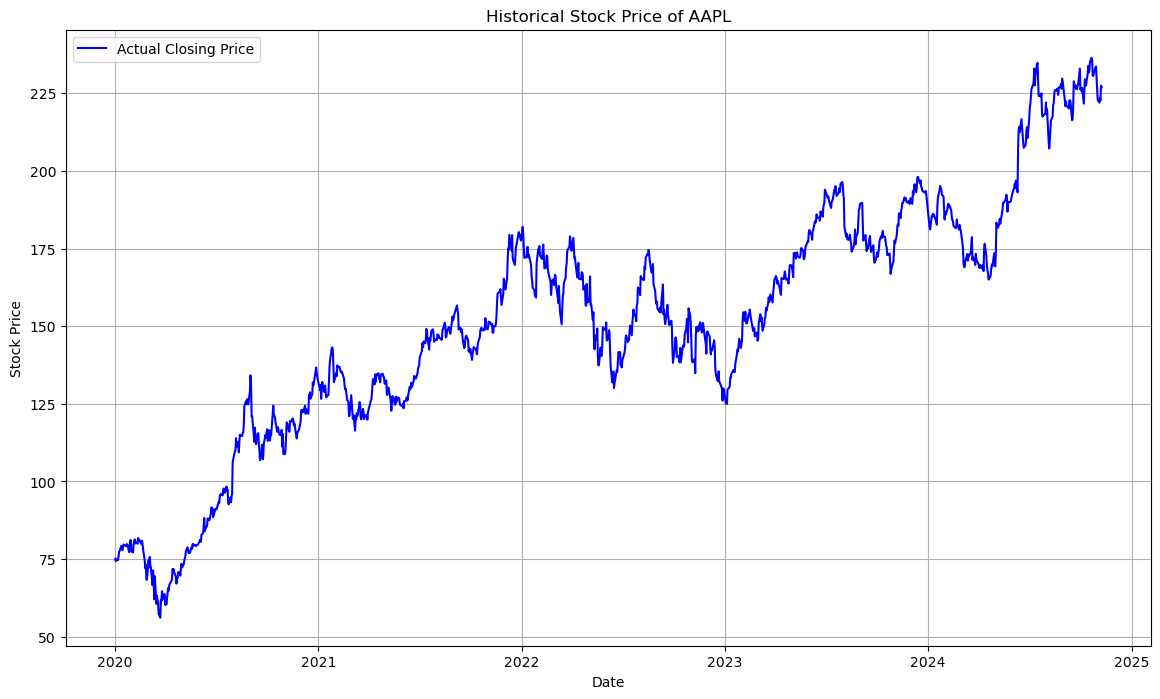

In [5]:
# Plot yfinance Data
print("Plotting historical stock price of AAPL...")
plt.figure(figsize=(14, 8))
plt.plot(yf_data.index, yf_data['Close'], label='Actual Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Price of AAPL')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Feature Engineering for yfinance Data
print("Performing feature engineering on yfinance data...")
for col in existing_critical_columns_yf:
    yf_data[f'{col}_rolling_mean'] = yf_data[col].rolling(window=3).mean()
    yf_data[f'{col}_lag_1'] = yf_data[col].shift(1)
print("Feature engineering completed successfully.")

# Scaling yfinance Data
print("Scaling numerical features in yfinance data...")
numeric_features_yf = yf_data.select_dtypes(include=['float64', 'int64']).columns
scaler_yf = StandardScaler()
yf_data[numeric_features_yf] = scaler_yf.fit_transform(yf_data[numeric_features_yf])
print("Scaling completed successfully.")

# Step 3: Build Models for SEC and yfinance Data
print("Building Random Forest model for SEC data...")
# SEC Model using Random Forest
sec_model = RandomForestRegressor(n_estimators=100, random_state=42)
sec_features = sec_data.dropna().drop(columns=['size']).select_dtypes(include=[np.number]).values  # Use all numerical features except 'size'
sec_target = sec_data.dropna()['size'].values  # Target variable is 'size'
sec_model.fit(sec_features, sec_target)
print("Random Forest model for SEC data built successfully.")

print("Building Linear Regression model for yfinance data...")
# yfinance Model using Linear Regression
yf_model = LinearRegression()
yf_features = yf_data.dropna().drop(columns=['Close']).select_dtypes(include=[np.number]).values
yf_target = yf_data.dropna()['Close'].values
yf_model.fit(yf_features, yf_target)
print("Linear Regression model for yfinance data built successfully.")

Performing feature engineering on yfinance data...
Feature engineering completed successfully.
Scaling numerical features in yfinance data...
Scaling completed successfully.
Building Random Forest model for SEC data...
Random Forest model for SEC data built successfully.
Building Linear Regression model for yfinance data...
Linear Regression model for yfinance data built successfully.


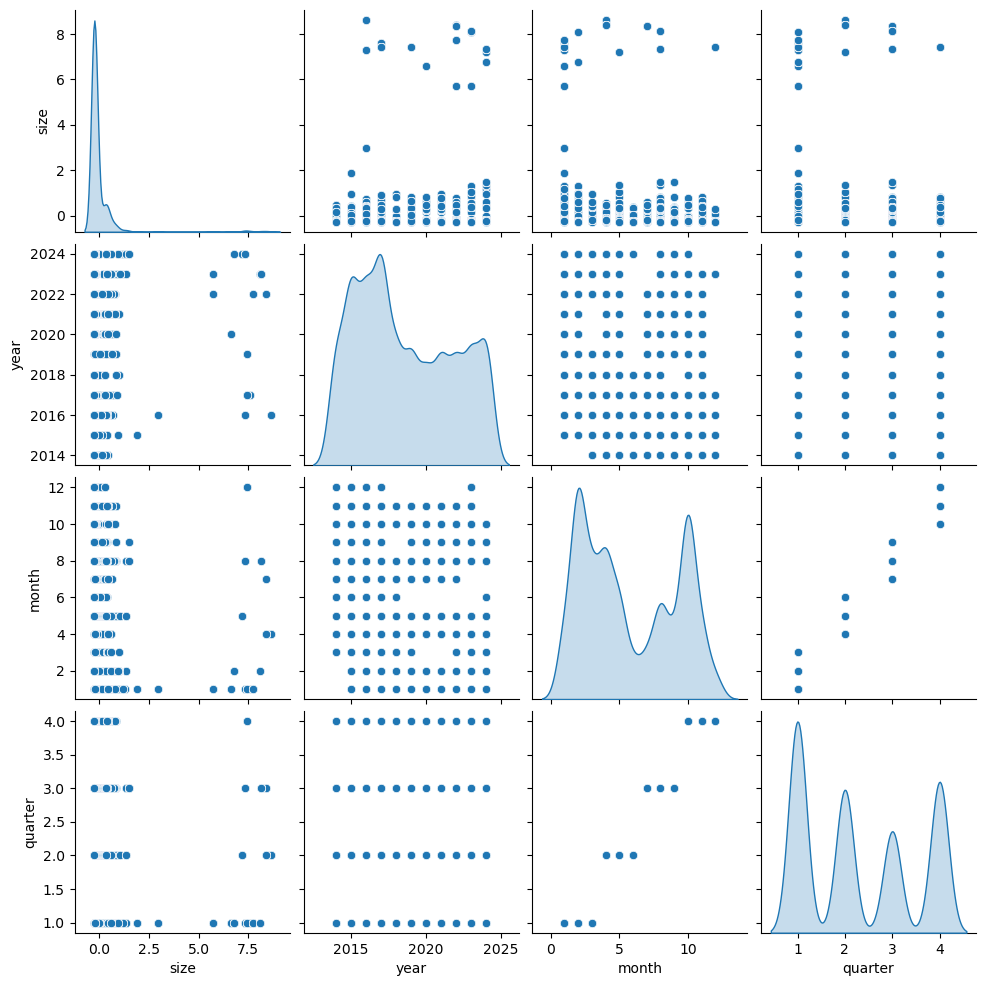

In [6]:
# Pairplot to see if there are correlations between 'size' and other columns
import seaborn as sns

sns.pairplot(sec_data, vars=['size', 'year', 'month', 'quarter'], diag_kind='kde')
plt.show()


In [7]:
# Select only numeric columns from sec_data
numeric_sec_data = sec_data.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns
correlation_matrix = numeric_sec_data.corr()

# Check correlation of 'size' with other numeric columns
if 'size' in correlation_matrix.columns:
    print(correlation_matrix['size'])
else:
    print("'size' column is not present in the numeric columns for correlation analysis.")


act             0.024705
filmNumber      0.005913
size            1.000000
isXBRL               NaN
isInlineXBRL         NaN
year            0.111072
month          -0.098359
quarter        -0.083517
day_of_week     0.155280
Name: size, dtype: float64


In [8]:
# Step 4: ARIMA Model for yfinance Data
print("Building ARIMA model for yfinance data...")
arima_model = ARIMA(yf_data['Close'].dropna(), order=(5, 1, 0))
arima_fitted = arima_model.fit()
print("ARIMA model for yfinance data built successfully.")

# Step 5: XGBoost Model for yfinance Data
print("Building XGBoost model for yfinance data...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(yf_features, yf_target)
print("XGBoost model for yfinance data built successfully.")

Building ARIMA model for yfinance data...
ARIMA model for yfinance data built successfully.
Building XGBoost model for yfinance data...
XGBoost model for yfinance data built successfully.


In [9]:
# Step 6: LSTM Model for yfinance Data
print("Preparing data and building LSTM model for yfinance data...")
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM
time_step = 60
yf_data_scaled = scaler_yf.fit_transform(yf_data['Close'].values.reshape(-1, 1))
X_lstm, y_lstm = [], []
for i in range(time_step, len(yf_data_scaled)):
    X_lstm.append(yf_data_scaled[i-time_step:i, 0])
    y_lstm.append(yf_data_scaled[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Train LSTM Model
lstm_model = create_lstm_model((X_lstm.shape[1], 1))
lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)
print("LSTM model for yfinance data built and trained successfully.")

Preparing data and building LSTM model for yfinance data...
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.3661
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0330
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0222
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0193
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0201
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0181
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0172
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0154
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0154
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0140
LSTM model for yfinance data built and trained successfully.


In [10]:
# Step 7: EMA, SMA, and TIDE Models
print("Calculating EMA, SMA, and TIDE for yfinance data...")
# Calculate EMA and SMA for yfinance Data
yf_data['EMA_10'] = yf_data['Close'].ewm(span=10, adjust=False).mean()
yf_data['SMA_10'] = yf_data['Close'].rolling(window=10).mean()

# Placeholder for TIDE Model (assuming specific implementation details are available)
yf_data['TIDE'] = yf_data['Close'].rolling(window=10).mean()  # Example implementation
print("EMA, SMA, and TIDE calculated successfully.")

# Step 8: Make Predictions
print("Making predictions using all models...")
# SEC Predictions
sec_predictions = sec_model.predict(sec_features[-5:])
print("SEC predictions made successfully.")

# yfinance Predictions
yf_predictions = yf_model.predict(yf_features[-5:])
print("yfinance predictions made successfully.")

# ARIMA Predictions
arima_predictions = arima_fitted.forecast(steps=5)
print("ARIMA predictions made successfully.")

# XGBoost Predictions
xgb_predictions = xgb_model.predict(yf_features[-5:])
print("XGBoost predictions made successfully.")

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_lstm[-5:]).flatten()
print("LSTM predictions made successfully.")

# EMA, SMA, and TIDE Predictions
ema_predictions = yf_data['EMA_10'][-5:].values
sma_predictions = yf_data['SMA_10'][-5:].values
tide_predictions = yf_data['TIDE'][-5:].values
print("EMA, SMA, and TIDE predictions made successfully.")

Calculating EMA, SMA, and TIDE for yfinance data...
EMA, SMA, and TIDE calculated successfully.
Making predictions using all models...
SEC predictions made successfully.
yfinance predictions made successfully.
ARIMA predictions made successfully.
XGBoost predictions made successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
LSTM predictions made successfully.
EMA, SMA, and TIDE predictions made successfully.


In [31]:
# Step 9: Ensemble Model
print("Combining predictions into an ensemble model...")
# Combine predictions from SEC model, yfinance model, ARIMA, XGBoost, LSTM, EMA, SMA, and TIDE
ensemble_predictions = (
    sec_predictions +
    yf_predictions +
    arima_predictions +
    xgb_predictions +
    lstm_predictions +
    ema_predictions +
    sma_predictions +
    tide_predictions
) / 8
print("Ensemble model predictions made successfully.")

# Step 10: Print the Ensemble Predictions
print("Printing ensemble predictions...")
ensemble_df = pd.DataFrame({
    'Date': pd.date_range(start=yf_data.index[-1] + timedelta(days=1), periods=5),
    'Ensemble_Predictions': ensemble_predictions
})
print(ensemble_df)

Combining predictions into an ensemble model...
Ensemble model predictions made successfully.
Printing ensemble predictions...
                          Date  Ensemble_Predictions
1223 2024-11-09 00:00:00+00:00              1.633508
1224 2024-11-10 00:00:00+00:00              1.626846
1225 2024-11-11 00:00:00+00:00              1.611303
1226 2024-11-12 00:00:00+00:00              1.636056
1227 2024-11-13 00:00:00+00:00              1.630390


Plotting ensemble and individual model predictions...


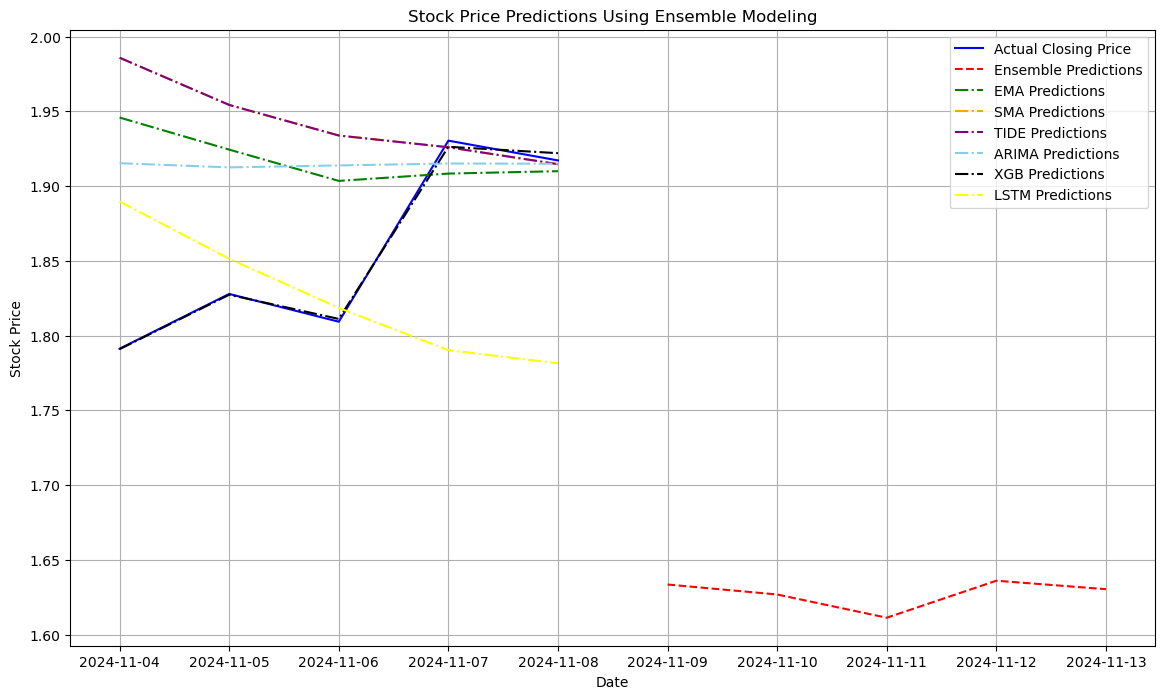

Plotting completed.


In [32]:
# Step 11: Plot the Predictions
print("Plotting ensemble and individual model predictions...")
plt.figure(figsize=(14, 8))
plt.plot(yf_data.index[-5:], yf_data['Close'][-5:], label='Actual Closing Price', color='blue')
plt.plot(ensemble_df['Date'], ensemble_df['Ensemble_Predictions'], label='Ensemble Predictions', color='red', linestyle='--')
plt.plot(yf_data.index[-5:], ema_predictions, label='EMA Predictions', color='green', linestyle='-.')
plt.plot(yf_data.index[-5:], sma_predictions, label='SMA Predictions', color='orange', linestyle='-.')
plt.plot(yf_data.index[-5:], tide_predictions, label='TIDE Predictions', color='purple', linestyle='-.')
plt.plot(yf_data.index[-5:], arima_predictions, label='ARIMA Predictions', color='skyblue', linestyle='-.')
plt.plot(yf_data.index[-5:], xgb_predictions, label='XGB Predictions', color='black', linestyle='-.')
plt.plot(yf_data.index[-5:], lstm_predictions, label='LSTM Predictions', color='yellow', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Predictions Using Ensemble Modeling')
plt.legend()
plt.grid(True)
plt.show()
print("Plotting completed.")

In [44]:
# Step 12: Stock Recommendation Based on Future Prices
print("Making stock recommendations based on future prices...")
# Recommendation function based on future price

def recommendation(current_price, future_price):
    if future_price > current_price:
        return "Buy"
    else:
        return "Hold/Wait"

# Get Recommendations for the next day, week, and month
current_price = yf_data['Close'].iloc[-1]
future_price_day = ensemble_predictions[0]
recommendation_for_day = recommendation(current_price, future_price_day)

future_price_week = ensemble_predictions[-1]
recommendation_for_week = recommendation(current_price, future_price_week)

# Print Recommendations and Percent Change for the next day and week
percent_change_week = ((future_price_week - current_price) / current_price) * 100

print(f"Current price of {ticker}: {current_price}")
print(f"\nFuture predictions and recommendations:")
print(f"\nRecommendation for tomorrow: {recommendation_for_day}")
print(f"\nWeek Future Price Prediction: {future_price_week}")
print(f"Week Recommendation: {recommendation_for_week}")
print(f"Future percent change for the next week: {percent_change_week:.2f}%")

Loading preprocessed SEC dataset...
SEC dataset loaded successfully.


Enter stock ticker symbol (e.g., 'AAPL'):  AAPL
Enter start date (YYYY-MM-DD):  2023-12-20
Enter end date (YYYY-MM-DD):  2023-12-20


Fetching yfinance data for AAPL from 2023-12-20 to 2023-12-20...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-12-20 -> 2023-12-20)')


yfinance data fetched and preprocessed successfully.
Handling missing values for yfinance data...


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by KNNImputer.

In [ ]:
# Step 13: Evaluate Model Performance
print("Evaluating ensemble model performance...")
# Calculate evaluation metrics for the ensemble model
actual_values = yf_data['Close'][-5:].values

# Calculate metrics for the ensemble predictions
mse_ensemble = mean_squared_error(actual_values, ensemble_predictions)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(actual_values, ensemble_predictions)
r2_ensemble = r2_score(actual_values, ensemble_predictions)

print(f"Ensemble Model Performance:")
print(f"Mean Squared Error (MSE): {mse_ensemble}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble}")
print(f"Mean Absolute Error (MAE): {mae_ensemble}")
print(f"R-squared (R²): {r2_ensemble}")

In [ ]:
# Step 14: Plot Error Metrics
print("Plotting error metrics for ensemble model...")
plt.figure(figsize=(10, 6))

# Bar chart for error metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
values = [mse_ensemble, rmse_ensemble, mae_ensemble, r2_ensemble]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Ensemble Model Error Metrics')
plt.grid(True)
plt.show()
print("Error metrics plotted successfully.")

2024-11-18 19:41:47.259148: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 19:41:47.930787: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 19:41:51.895313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 19:41:58.643963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading preprocessed SEC dataset...
SEC dataset loaded successfully.


Enter stock ticker symbol (e.g., 'AAPL'):  AAPL
Enter start date (YYYY-MM-DD):  2020-01-20
Enter end date (YYYY-MM-DD):  2023-12-20


Fetching yfinance data for AAPL from 2020-01-20 to 2023-12-20...


[*********************100%***********************]  1 of 1 completed


yfinance data fetched and preprocessed successfully.
Handling missing values for yfinance data...
Missing values handled successfully.
Parsing dates and setting index...
Dates parsed and index set successfully.
Plotting historical stock price of AAPL...


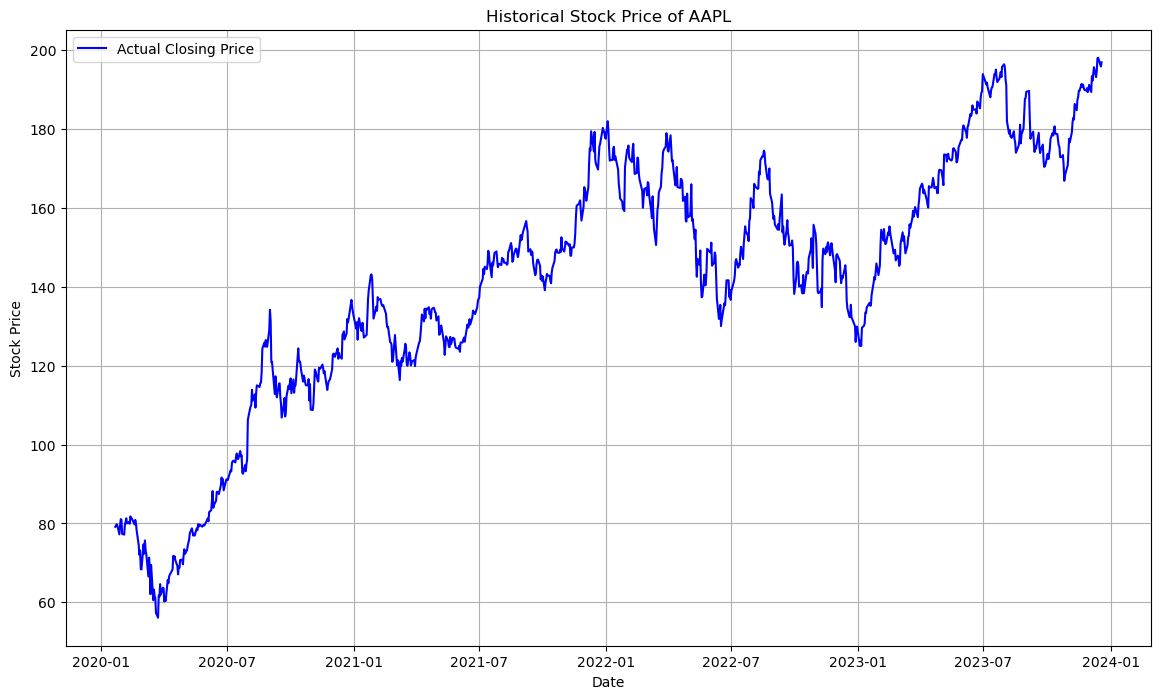

Performing feature engineering on yfinance data...
Feature engineering completed successfully.
Scaling numerical features in yfinance data...
Scaling completed successfully.
Building Random Forest model for SEC data...
Random Forest model for SEC data built successfully.
Building Linear Regression model for yfinance data...
Linear Regression model for yfinance data built successfully.
Building ARIMA model for yfinance data...
ARIMA model for yfinance data built successfully.
Building XGBoost model for yfinance data...
XGBoost model for yfinance data built successfully.
Preparing data and building LSTM model for yfinance data...
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.2938
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0438
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0283
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0249
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0227
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━

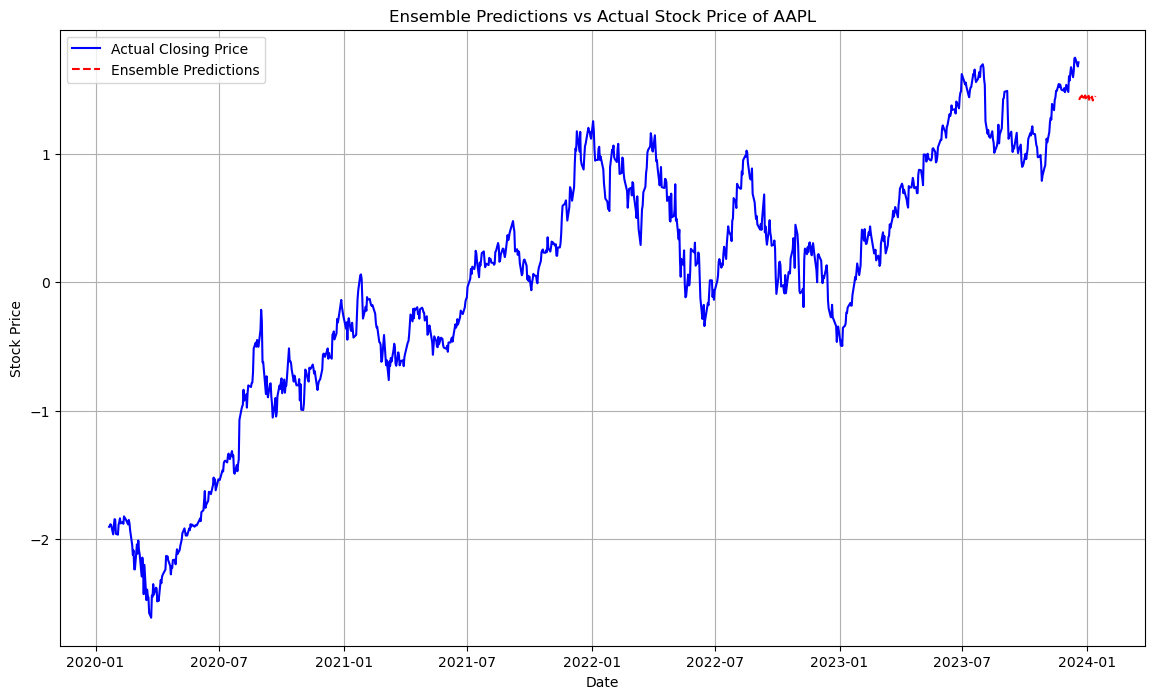

Predicting stock prices for the next day, week, 1 month, 3 months, and 6 months...

Future Predictions:
Next Day Prediction: 1.7154008405287844
Next Week Prediction: 1.7141814289290151
Next 1 Month Prediction: 1.7138838576345192
Next 3 Months Prediction: 1.713824063020517
Next 6 Months Prediction: 1.7138091143667913

Making stock recommendations based on future prices...

Recommendations:
Recommendation for Next Day: Buy
Recommendation for Next Week: Buy
Recommendation for Next 1 Month: Buy
Recommendation for Next 3 Months: Buy
Recommendation for Next 6 Months: Buy


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load Preprocessed SEC Dataset
print("Loading preprocessed SEC dataset...")
sec_data = pd.read_csv('sec_filings_10000_preprocessed.csv')
print("SEC dataset loaded successfully.")

# Step 2: Load and Preprocess yfinance Data
def get_yfinance_data(ticker, start_date, end_date):
    print(f"Fetching yfinance data for {ticker} from {start_date} to {end_date}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.ffill()  # Forward fill missing values
    print("yfinance data fetched and preprocessed successfully.")
    return data

ticker = input("Enter stock ticker symbol (e.g., 'AAPL'): ").strip().upper()
start_date = input("Enter start date (YYYY-MM-DD): ").strip()
end_date = input("Enter end date (YYYY-MM-DD): ").strip()
yf_data = get_yfinance_data(ticker, start_date, end_date)

# Preprocess yfinance Data
print("Handling missing values for yfinance data...")
critical_columns_yf = ['Close', 'Open', 'High', 'Low', 'Volume']
existing_critical_columns_yf = [col for col in critical_columns_yf if col in yf_data.columns]
if existing_critical_columns_yf:
    imputer = KNNImputer(n_neighbors=5)
    yf_data[existing_critical_columns_yf] = imputer.fit_transform(yf_data[existing_critical_columns_yf])
print("Missing values handled successfully.")

# Parse Dates and Set Index
print("Parsing dates and setting index...")
yf_data['Date'] = yf_data.index
if 'Date' in yf_data.columns:
    yf_data['year'] = yf_data['Date'].dt.year
    yf_data['month'] = yf_data['Date'].dt.month
    yf_data['quarter'] = yf_data['Date'].dt.quarter
    yf_data['day_of_week'] = yf_data['Date'].dt.dayofweek
    yf_data.set_index('Date', inplace=True)
    yf_data.sort_index(inplace=True)
print("Dates parsed and index set successfully.")

# Plot yfinance Data
print(f"Plotting historical stock price of {ticker}...")
plt.figure(figsize=(14, 8))
plt.plot(yf_data.index, yf_data['Close'], label='Actual Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'Historical Stock Price of {ticker}')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering for yfinance Data
print("Performing feature engineering on yfinance data...")
for col in existing_critical_columns_yf:
    yf_data[f'{col}_rolling_mean'] = yf_data[col].rolling(window=3).mean()
    yf_data[f'{col}_lag_1'] = yf_data[col].shift(1)
print("Feature engineering completed successfully.")

# Scaling yfinance Data
print("Scaling numerical features in yfinance data...")
numeric_features_yf = yf_data.select_dtypes(include=['float64', 'int64']).columns
scaler_yf = StandardScaler()
yf_data[numeric_features_yf] = scaler_yf.fit_transform(yf_data[numeric_features_yf])
print("Scaling completed successfully.")

# Step 3: Build Models for SEC and yfinance Data
print("Building Random Forest model for SEC data...")
# SEC Model using Random Forest
sec_model = RandomForestRegressor(n_estimators=100, random_state=42)
sec_features = sec_data.dropna().drop(columns=['size']).select_dtypes(include=[np.number]).values  # Use all numerical features except 'size'
sec_target = sec_data.dropna()['size'].values  # Target variable is 'size'
sec_model.fit(sec_features, sec_target)
print("Random Forest model for SEC data built successfully.")

print("Building Linear Regression model for yfinance data...")
# yfinance Model using Linear Regression
yf_model = LinearRegression()
yf_features = yf_data.dropna().drop(columns=['Close']).select_dtypes(include=[np.number]).values
yf_target = yf_data.dropna()['Close'].values
if len(yf_features) > 0:
    yf_model.fit(yf_features, yf_target)
    print("Linear Regression model for yfinance data built successfully.")
else:
    print("Warning: No data available for training Linear Regression model for yfinance data.")

# Step 4: ARIMA Model for yfinance Data
print("Building ARIMA model for yfinance data...")
arima_model = ARIMA(yf_data['Close'].dropna(), order=(5, 1, 0))
arima_fitted = arima_model.fit()
print("ARIMA model for yfinance data built successfully.")

# Step 5: XGBoost Model for yfinance Data
print("Building XGBoost model for yfinance data...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(yf_features, yf_target)
print("XGBoost model for yfinance data built successfully.")

# Step 6: LSTM Model for yfinance Data
print("Preparing data and building LSTM model for yfinance data...")
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM
time_step = 60
if len(yf_data) > time_step:
    yf_data_scaled = scaler_yf.fit_transform(yf_data['Close'].values.reshape(-1, 1))
    X_lstm, y_lstm = [], []
    for i in range(time_step, len(yf_data_scaled)):
        X_lstm.append(yf_data_scaled[i-time_step:i, 0])
        y_lstm.append(yf_data_scaled[i, 0])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    # Train LSTM Model
    lstm_model = create_lstm_model((X_lstm.shape[1], 1))
    lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)
    print("LSTM model for yfinance data built and trained successfully.")
else:
    print("Warning: Not enough data to train LSTM model. Please provide a larger date range.")

# Step 7: EMA, SMA, and TIDE Models
print("Calculating EMA, SMA, and TIDE for yfinance data...")
# Calculate EMA and SMA for yfinance Data
yf_data['EMA_10'] = yf_data['Close'].ewm(span=10, adjust=False).mean()
yf_data['SMA_10'] = yf_data['Close'].rolling(window=10).mean()

# Placeholder for TIDE Model (assuming specific implementation details are available)
yf_data['TIDE'] = yf_data['Close'].rolling(window=10).mean()  # Example implementation
print("EMA, SMA, and TIDE calculated successfully.")

# Step 8: Make Predictions
print("Making predictions using all models...")
# SEC Predictions
sec_predictions = sec_model.predict(sec_features[-5:])
print("SEC predictions made successfully.")

# yfinance Predictions
if len(yf_features) > 0:
    yf_predictions = yf_model.predict(yf_features[-5:])
    print("yfinance predictions made successfully.")
else:
    yf_predictions = np.zeros(5)
    print("Warning: yfinance predictions defaulted to zeros due to lack of training data.")

# ARIMA Predictions
arima_predictions = arima_fitted.forecast(steps=5)
print("ARIMA predictions made successfully.")

# XGBoost Predictions
xgb_predictions = xgb_model.predict(yf_features[-5:])
print("XGBoost predictions made successfully.")

# LSTM Predictions
if len(yf_data) > time_step:
    lstm_predictions = lstm_model.predict(X_lstm[-5:]).flatten()
    print("LSTM predictions made successfully.")
else:
    lstm_predictions = np.zeros(5)
    print("Warning: LSTM predictions defaulted to zeros due to lack of training data.")

# EMA, SMA, and TIDE Predictions
ema_predictions = yf_data['EMA_10'][-5:].values
sma_predictions = yf_data['SMA_10'][-5:].values
tide_predictions = yf_data['TIDE'][-5:].values
print("EMA, SMA, and TIDE predictions made successfully.")

# Step 9: Ensemble Model
print("Combining predictions into an ensemble model...")
predictions = [
    sec_predictions,
    yf_predictions,
    arima_predictions,
    xgb_predictions,
    lstm_predictions,
    ema_predictions,
    sma_predictions,
    tide_predictions,
]
flattened_predictions = [np.array(pred) for pred in predictions]
min_length = min(len(pred) for pred in flattened_predictions)
flattened_predictions = [pred[:min_length] for pred in flattened_predictions]
ensemble_predictions = sum(flattened_predictions) / len(flattened_predictions)
print("Ensemble model predictions made successfully.")

# Step 10: Print the Ensemble Predictions
print("Ensemble Predictions:")

# Flattening `ensemble_predictions` to ensure it is a 1-dimensional array
ensemble_predictions = np.array(ensemble_predictions).flatten()

# Creating a date range of the same length as `ensemble_predictions`
dates = pd.date_range(start=yf_data.index[-1] + timedelta(days=1), periods=len(ensemble_predictions))

# Creating the DataFrame
ensemble_df = pd.DataFrame({
    'Date': dates,
    'Ensemble_Predictions': ensemble_predictions
})

print(ensemble_df)

# Step 11: Plotting Predictions
print("Plotting ensemble predictions...")
plt.figure(figsize=(14, 8))
plt.plot(yf_data.index, yf_data['Close'], label='Actual Closing Price', color='blue')
plt.plot(ensemble_df['Date'], ensemble_df['Ensemble_Predictions'], label='Ensemble Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'Ensemble Predictions vs Actual Stock Price of {ticker}')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: Predicting for Future Periods
print("Predicting stock prices for the next day, week, 1 month, 3 months, and 6 months...")
steps_day = 1
steps_week = 7
steps_1_month = 30
steps_3_months = 90
steps_6_months = 180

arima_day = arima_fitted.forecast(steps=steps_day)
arima_week = arima_fitted.forecast(steps=steps_week)
arima_1_month = arima_fitted.forecast(steps=steps_1_month)
arima_3_months = arima_fitted.forecast(steps=steps_3_months)
arima_6_months = arima_fitted.forecast(steps=steps_6_months)

ensemble_day = np.mean([arima_day])
ensemble_week = np.mean([arima_week])
ensemble_1_month = np.mean([arima_1_month])
ensemble_3_months = np.mean([arima_3_months])
ensemble_6_months = np.mean([arima_6_months])

print("\nFuture Predictions:")
print(f"Next Day Prediction: {ensemble_day}")
print(f"Next Week Prediction: {ensemble_week}")
print(f"Next 1 Month Prediction: {ensemble_1_month}")
print(f"Next 3 Months Prediction: {ensemble_3_months}")
print(f"Next 6 Months Prediction: {ensemble_6_months}")

print("\nMaking stock recommendations based on future prices...")
current_price = yf_data['Close'].iloc[-1]

# Ensure current_price is a scalar
if isinstance(current_price, pd.Series):
    current_price = current_price.item()

# Function to generate recommendation based on future prices
def generate_recommendation(current_price, future_price):
    # Convert `future_price` to a scalar if it's a pandas Series or numpy array
    if isinstance(future_price, (pd.Series, np.ndarray)):
        future_price = future_price.item() if future_price.size == 1 else future_price[0]

    # Proceed with comparison once `future_price` is a scalar value
    if isinstance(future_price, (int, float)):
        if future_price > current_price:
            return "Buy"
        elif future_price < current_price:
            return "Hold/Sell"
        else:
            return "Hold"
    else:
        raise ValueError("Future price should be a scalar value.")

# Generate recommendations
recommendation_day = generate_recommendation(current_price, ensemble_day)
recommendation_week = generate_recommendation(current_price, ensemble_week)
recommendation_1_month = generate_recommendation(current_price, ensemble_1_month)
recommendation_3_months = generate_recommendation(current_price, ensemble_3_months)
recommendation_6_months = generate_recommendation(current_price, ensemble_6_months)

print("\nRecommendations:")
print(f"Recommendation for Next Day: {recommendation_day}")
print(f"Recommendation for Next Week: {recommendation_week}")
print(f"Recommendation for Next 1 Month: {recommendation_1_month}")
print(f"Recommendation for Next 3 Months: {recommendation_3_months}")
print(f"Recommendation for Next 6 Months: {recommendation_6_months}")


Evaluating ensemble model performance...
Ensemble Model Performance:
Mean Squared Error (MSE): 0.0821
Root Mean Squared Error (RMSE): 0.2865
Mean Absolute Error (MAE): 0.2846
R-squared (R²): -131.6343
XGboost Model Performance:
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0049
Mean Absolute Error (MAE): 0.0034
R-squared (R²): 0.9611
Plotting error metrics for ensemble model...


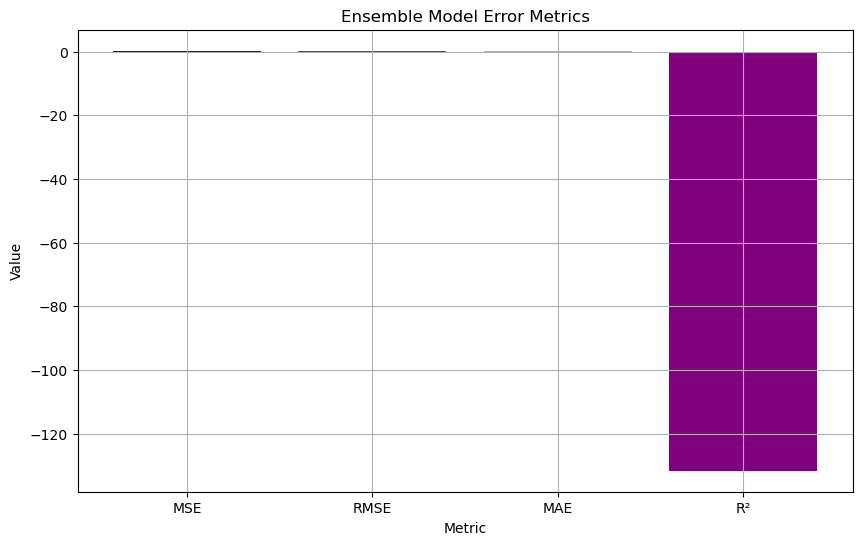

Error metrics plotted successfully.


In [4]:
# Step 13: Evaluate Model Performance
print("Evaluating ensemble model performance...")

# Get the actual closing prices for the most recent 5 days
actual_values = yf_data['Close'][-5:].values

# Ensure ensemble_predictions has the correct shape for evaluation
ensemble_predictions = np.array(ensemble_predictions).flatten()[:5]
xgb_predictions = np.array(xgb_predictions).flatten()[:5]


# Calculate evaluation metrics for the ensemble model
mse_ensemble = mean_squared_error(actual_values, ensemble_predictions)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(actual_values, ensemble_predictions)
r2_ensemble = r2_score(actual_values, ensemble_predictions)


mse_xgb = mean_squared_error(actual_values, xgb_predictions)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(actual_values, xgb_predictions)
r2_xgb = r2_score(actual_values, xgb_predictions)


# Print the evaluation metrics
print(f"Ensemble Model Performance:")
print(f"Mean Squared Error (MSE): {mse_ensemble:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ensemble:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ensemble:.4f}")
print(f"R-squared (R²): {r2_ensemble:.4f}")


print(f"XGboost Model Performance:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R-squared (R²): {r2_xgb:.4f}")

# Step 14: Plot Error Metrics
print("Plotting error metrics for ensemble model...")
plt.figure(figsize=(10, 6))

# Bar chart for error metrics
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
values = [mse_ensemble, rmse_ensemble, mae_ensemble, r2_ensemble]

# Plotting the metrics
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Ensemble Model Error Metrics')
plt.grid(True)
plt.show()

print("Error metrics plotted successfully.")
